In [42]:
import pandas as pd
import os

def get_files(dir: str, prefix: str = '', suffix: str = '') -> list:
    """Get all files in a directory with a specific prefix and suffix."""
    files = []
    for root, dirs, filenames in os.walk(dir):
        for filename in filenames:
            if filename.startswith(prefix) and filename.endswith(suffix):
                files.append(os.path.join(root, filename))
    return files



def merge_results():
    file_dris = {
        'SqaureAttackGenerator': [
            r'C:\Users\z8701\Documents\MyPaper\YOLO_paper\latex\NeurIPS\data\merged_results_full.csv',
        ],
        'SampleBoundsGenerator': [
            r'C:\Users\z8701\Documents\MyPaper\YOLO_paper\latex\NeurIPS\data\verification_results_full.csv',
        ],
        'd' : [
            r'C:\Users\z8701\Documents\MyPaper\YOLO_paper\latex\NeurIPS\data\merged_results_pgd.csv'
        ]
    }

    full_df = pd.DataFrame(
        columns=[
            'model', 'image', 'epsilon','box_index', 'method', 'iou_0.5', 'iou_0.7',  'time'
        ]
    )

    for generator_name, dirs in file_dris.items():
        files = dirs[0]
        df = pd.read_csv(files)
        # add to full_df
        full_df = pd.concat([full_df, df], ignore_index=True)
                # add to data_frames
    # sort full_df by model, image, box_index, epsilon, method
    full_df = full_df.sort_values(by=['model', 'image', 'epsilon','box_index', 'method'])

    full_df.to_csv('./merge_other_full.csv', index=False)
    print(f"Saved merged results to ./merge_other_full.csv")

merge_results()

C:\Users\z8701\AppData\Local\Temp\ipykernel_23856\838340646.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([full_df, df], ignore_index=True)


Saved merged results to ./merge_other_full.csv


41


C:\Users\z8701\AppData\Local\Temp\ipykernel_23856\1318548031.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle(


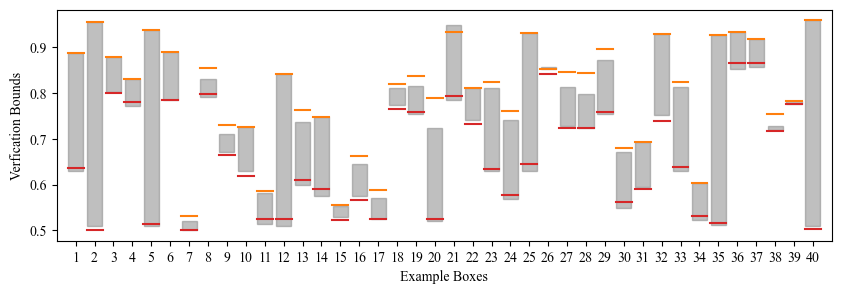

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.patches import Rectangle
from matplotlib import rcParams

# 设置字体为 Times New Roman
rcParams['font.family'] = 'Times New Roman'
csv_path = r'./merged_results_each_with_pgd.csv'

df = pd.read_csv(csv_path)
methods = df['method'].unique()
# 以image,epsilon,box_index为索引进行分组
grouped = df.groupby(['model', 'image', 'epsilon', 'box_index'])
select_methods = [
    'pgd_attack_iter[20]',
    'sample_bounds',
    'square_attack',
    'verification'
]
count = 0
datas = []
for group_name, group in grouped:
    # 只选择特定方法进行绘图
    group = group[group['method'].isin(select_methods)]
    # 绘制每个组的图形

    if abs(group[group['method'] == 'verification']['iou_0.5'].values - group[group['method'].values == 'pgd_attack_iter[20]']['iou_0.5'].values) < 0.015:
        if group[group['method'] == 'verification']['iou_0.5'].values < group[group['method'] == 'sample_bounds']['iou_0.5'].values and group[group['method'] == 'verification']['iou_0.5'].values < group[group['method'] == 'square_attack']['iou_0.5'].values:
            # if abs(group[group['method'] == 'sample_bounds']['iou_0.5'].values - group[group['method'] == 'square_attack']['iou_0.5'].values) >= 0:
            datas.append(group)

# 在一张图上，比较每组数据的iou_0.5值。每组数据绘制一个小横线，依次排开.横坐标是第几组(不用标明)，纵坐标是iou_0.5的值。同一种方法用相同的颜色表示。
fig, ax = plt.subplots(figsize=(10, 3))
# 用于跟踪哪些方法已经添加到图例中
added_methods = set()
color_map = plt.get_cmap('tab10')  # 使用 'tab10' 颜色映射
method_colors = {method: color_map(i) for i, method in enumerate(select_methods)}

print(len(datas))
for i, data in enumerate(datas[:40]):
    # 只选择特定方法进行绘图
    data = data[data['method'].isin(select_methods)]
    # 绘制每个组的图形
    for method in select_methods:
        method_data = data[data['method'] == method]
        if not method_data.empty:
            # 获取该方法的颜色
            color = method_colors[method]
            # 仅在方法未添加到图例时设置 label
            if method == 'pgd_attack_iter[20]' or method == 'square_attack':
                continue
            if method not in added_methods:
                ax.plot([i-0.42+1, i + 0.42+1], [method_data['iou_0.5'].values[0], method_data['iou_0.5'].values[0]],
                        label=method, color=color)
                added_methods.add(method)
            else:
                ax.plot([i-0.42+1, i + 0.42+1], [method_data['iou_0.5'].values[0], method_data['iou_0.5'].values[0]],
                        color=color)
    square_attack_value = data['iou_0.5'][data['method'] == 'square_attack'].values[0]
    sample_bounds_value = data['iou_0.5'][data['method'] == 'pgd_attack_iter[20]'].values[0]
    rect = Rectangle(
        (i-0.4 + 1, min(square_attack_value, sample_bounds_value)),  # 左下角坐标
        0.8,  # 矩形的宽度
        abs(sample_bounds_value - square_attack_value),  # 矩形的高度
        color='gray',  # 矩形颜色
        alpha=0.5,  # 透明度
        edgecolor='none'  # 移除边框
    )

    # 将矩形添加到图中
    ax.add_patch(rect)

# 设置坐标轴标签和标题
ax.set_xlim(left=0, right=41)  # 设置显示范围从 0.5 开始，以确保第一个刻度 1 可见
ax.set_xticks(range(1, len(datas[:40]) + 1))
ax.set_xlabel('Example Boxes')
ax.set_ylabel('Verfication Bounds')
# ax.set_title('Comparison of Verfication Bounds for Different Methods')
plt.savefig('./merged_results_each_with_pgd.svg', bbox_inches='tight', format='svg')
# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D
# # 定义自定义图例项
# custom_legend = [
#     Patch(facecolor='gray', edgecolor='none', alpha=0.5, label='Sample (top) & Verification (bottom)'),
#     Line2D([0], [0], color='black', lw=1, label='square attack (top)'),  # 顶部线条标注
#     Line2D([0], [0], color='black', lw=1, linestyle='--', label='pgd attack (bottom)')  # 底部线条标注
# ]

# # 设置图例在标题下方横向排列
# ax.legend(
#     handles=custom_legend,  # 使用自定义图例项
#     title='', 
#     frameon=False,
#     loc='upper center', 
#     bbox_to_anchor=(0.5, 1.2),  # 调整图例位置到标题上方
#     ncol=1  # 设置图例为纵向排列
# )

In [ ]:
import pandas as pd
import pandas as pd
import os # Assuming os is needed if you uncomment the file operations later
import numpy as np
from typing import List, Optional # Added for type hinting


def escape_latex(text_val, from_col=None) -> str:
    """Escapes special LaTeX characters in a string."""
    if pd.isna(text_val):
        return ""
    if text_val == np.inf:
        return "0.00"
    if isinstance(text_val, float) or isinstance(text_val, int) or isinstance(text_val,np.float64) or isinstance(text_val,np.int64) or isinstance(text_val, np.int32) or isinstance(text_val, np.float32):
        if from_col == 'verified':
            text = f"{text_val:.2f}"
        else:
            text = f"{text_val:.1f}" # Scientific notation
    else:
        text = str(text_val)
    
    # Order is important: replace backslash first, then other characters.
    text = text.replace('\\', '\\textbackslash{}') \
               .replace('&', '\\&').replace('%', '\\%') \
               .replace('#', '\\#').replace('_', '\\_').replace('{', '\\{') \
               .replace('}', '\\}').replace('~', '\\textasciitilde{}') \
               .replace('^', '\\textasciicircum{}')
    return text

def df_to_latex_multirow(df: pd.DataFrame) -> str:
    """
    Converts a CSV file to a LaTeX table string with multirow support for merged cells
    and appropriate horizontal lines using \cline.
    """

    num_rows, num_cols = df.shape
    if num_rows == 0:
        # Create a header line even for an empty data table
        if num_cols > 0:
            header_escaped = [escape_latex(col) for col in df.columns]
            header_str = " & ".join(header_escaped) + " \\\\"
            col_format_str = "l" * num_cols # Default to left alignment
            return f"\\begin{{tabular}}{{{col_format_str}}}\n\\hline\n{header_str}\n\\hline\n\\end{{tabular}}"
        else:
            return "\\begin{tabular}{}\n\\hline\n\\hline\n\\end{tabular}"


    output_grid = [[escape_latex(df.iloc[r, c]) for c in range(num_cols)] for r in range(num_rows)]
    active_multirow_end_row = [-1] * num_cols

    for r in range(num_rows):
        for c in range(num_cols):
            if r <= active_multirow_end_row[c]:
                output_grid[r][c] = "" 
                continue

            current_val = df.iloc[r, c]
            span = 1
            for k in range(r + 1, num_rows):
                if df.iloc[k, c] != current_val:
                    break
                
                prev_cols_aligned = True
                for prev_c in range(c):
                    if df.iloc[k, prev_c] != df.iloc[r, prev_c]:
                        prev_cols_aligned = False
                        break
                
                if not prev_cols_aligned:
                    break
                span += 1
            
            if span > 1:
                output_grid[r][c] = f"\\multirow{{{span}}}{{*}}{{{escape_latex(current_val)}}}"
                active_multirow_end_row[c] = r + span - 1

    header_escaped = [escape_latex(col) for col in df.columns]
    header_str = " & ".join(header_escaped) + " \\\\"
    
    col_formats = []
    for col_idx in range(num_cols):
        is_numeric = False
        try:
            # Attempt to convert to numeric, dropna to handle potential mixed types gracefully for check
            pd.to_numeric(df.iloc[:, col_idx].dropna())
            # Check if original non-NaN values were all numeric (handles cases like object dtype with numbers)
            if df.iloc[:, col_idx].dropna().apply(lambda x: isinstance(x, (int, float))).all():
                 is_numeric = True
        except ValueError:
            is_numeric = False
            
        if is_numeric:
            col_formats.append('r')
        else:
            col_formats.append('l')
    col_format_str = "".join(col_formats)

    latex_string = f"\\begin{{tabular}}{{{col_format_str}}}\n"
    latex_string += "\\hline\n" 
    latex_string += header_str + "\n"
    latex_string += "\\hline\n" 

    for r in range(num_rows):
        if r > 0:
            needs_cline = False
            first_diff_col_idx = -1 # 0-indexed
            # Find the first column where the current row differs from the previous one,
            # indicating a break in a merged block.
            for c_check in range(num_cols):
                if df.iloc[r, c_check] != df.iloc[r-1, c_check]:
                    # Ensure all preceding columns were identical to confirm hierarchical break
                    is_hierarchical_break = True
                    for prev_c in range(c_check):
                        if df.iloc[r, prev_c] != df.iloc[r-1, prev_c]:
                            is_hierarchical_break = False
                            break
                    if is_hierarchical_break:
                        needs_cline = True
                        first_diff_col_idx = c_check
                        break
            
            if needs_cline:
                # \cline should start from the first differing column (1-indexed)
                # and span to the last column.
                latex_string += f"\\cline{{{first_diff_col_idx + 1}-{num_cols}}}\n"

        row_content_str = " & ".join(output_grid[r]) + " \\\\"
        latex_string += row_content_str + "\n"

    latex_string += "\\hline\n"
    latex_string += "\\end{tabular}\n"
    return latex_string



def df_to_latex_multirow2(df: pd.DataFrame, columns_to_merge: Optional[List[str]] = None) -> str:
    """
    Converts a DataFrame to a LaTeX table string with multirow support for merged cells
    in specified columns and appropriate horizontal lines using \cline.
    If columns_to_merge is None, attempts to merge all columns hierarchically.
    Otherwise, only columns named in columns_to_merge will receive \multirow commands.
    Merged columns will not have internal horizontal lines from \cline.
    """

    num_rows, num_cols = df.shape
    if num_rows == 0:
        if num_cols > 0:
            header_escaped = [escape_latex(col, df.columns[c]) for col in df.columns]
            header_str = " & ".join(header_escaped) + " \\\\"
            col_format_str = "l" * num_cols
            return f"\\begin{{tabular}}{{{col_format_str}}}\n\\hline\n{header_str}\n\\hline\n\\end{{tabular}}"
        else:
            return "\\begin{tabular}{}\n\\hline\n\\hline\n\\end{tabular}"

    output_grid = [[escape_latex(df.iloc[r, c], df.columns[c]) for c in range(num_cols)] for r in range(num_rows)]
    active_multirow_end_row = [-1] * num_cols
    is_blanked_by_multirow = [[False for _ in range(num_cols)] for _ in range(num_rows)]

    eligible_for_multirow_command = [False] * num_cols
    if columns_to_merge is None:
        eligible_for_multirow_command = [True] * num_cols
    else:
        for c_idx, col_name in enumerate(df.columns):
            if col_name in columns_to_merge:
                eligible_for_multirow_command[c_idx] = True

    for r in range(num_rows):
        for c in range(num_cols):
            if r <= active_multirow_end_row[c]: 
                output_grid[r][c] = ""
                is_blanked_by_multirow[r][c] = True # Mark as blanked due to multirow
                continue

            current_val = df.iloc[r, c]
            span = 1
            for k in range(r + 1, num_rows):
                if df.iloc[k, c] != current_val:
                    break
                
                apply_hierarchical_constraint = True
                if columns_to_merge is not None and eligible_for_multirow_command[c]:
                    apply_hierarchical_constraint = False
                
                if apply_hierarchical_constraint:
                    prev_cols_aligned = True
                    for prev_c in range(c):
                        if df.iloc[k, prev_c] != df.iloc[r, prev_c]:
                            prev_cols_aligned = False
                            break
                    if not prev_cols_aligned:
                        break
                span += 1
            
            if span > 1 and eligible_for_multirow_command[c]:
                output_grid[r][c] = f"\\multirow{{{span}}}{{*}}{{{escape_latex(current_val)}}}"
                active_multirow_end_row[c] = r + span - 1
            # else: output_grid[r][c] already has escape_latex(current_val) from initialization

    header_escaped = [escape_latex(col) for col in df.columns]
    header_str = " & ".join(header_escaped) + " \\\\"
    
    col_formats = []
    for col_idx in range(num_cols):
        is_numeric = False
        try:
            if pd.to_numeric(df.iloc[:, col_idx].dropna(), errors='raise').dtype in [np.int64, np.float64, np.int32, np.float32]:
                 is_numeric = True
            # Further check if all non-NaN were numeric if original type was object
            elif df.iloc[:, col_idx].dropna().apply(lambda x: isinstance(x, (int, float))).all() and not df.iloc[:, col_idx].dropna().empty:
                is_numeric = True
        except (ValueError, TypeError):
            is_numeric = False
            
        if is_numeric:
            col_formats.append('r')
        else:
            col_formats.append('l')
    col_format_str = "".join(col_formats)

    latex_string = f"\\begin{{tabular}}{{{col_format_str}}}\n"
    latex_string += "\\hline\n" 
    latex_string += header_str + "\n"
    latex_string += "\\hline\n" 

    for r in range(num_rows):
        if r > 0:
            first_hierarchical_diff_col_idx = -1
            for c_check in range(num_cols):
                if df.iloc[r, c_check] != df.iloc[r-1, c_check]:
                    is_true_hierarchical_break = True
                    for prev_c in range(c_check):
                        if df.iloc[r, prev_c] != df.iloc[r-1, prev_c]:
                            is_true_hierarchical_break = False
                            break
                    if is_true_hierarchical_break:
                        first_hierarchical_diff_col_idx = c_check
                        break
            
            if first_hierarchical_diff_col_idx != -1:
                cline_segments = []
                current_segment_start = -1
                for c_segment in range(first_hierarchical_diff_col_idx, num_cols):
                    # A cell (r, c_segment) is protected if it's blanked by a multirow from above
                    is_protected = is_blanked_by_multirow[r][c_segment]

                    if not is_protected:
                        if current_segment_start == -1:
                            current_segment_start = c_segment
                    else: # is_protected
                        if current_segment_start != -1:
                            # End current segment before this protected column
                            cline_segments.append(f"\\cline{{{current_segment_start + 1}-{c_segment}}}")
                            current_segment_start = -1
                
                if current_segment_start != -1:
                    # Last segment goes to the end of the table
                    cline_segments.append(f"\\cline{{{current_segment_start + 1}-{num_cols}}}")
                
                if cline_segments:
                    latex_string += "".join(cline_segments) + "\n"

        row_content_str = " & ".join(output_grid[r]) + " \\\\"
        latex_string += row_content_str + "\n"

    latex_string += "\\hline\n"
    latex_string += "\\end{tabular}\n"
    return latex_string

if __name__ == '__main__':
    csv_path = r'.\merge_other_full.csv'
    df = pd.read_csv(csv_path)
    df.replace(np.inf, 0, inplace=True)

    group_data = df.groupby(['model', 'epsilon', 'image', 'box_index'])
    delete_list = []
    for group_name, group in group_data:
        # get by method
        if 'verification' in group['method'].values and 'sample_bounds' in group['method'].values:
            # if group[group['method'] == 'verification']['iou_0.5'].values[0] > group[group['method'] == 'sample_bounds']['iou_0.5'].values[0]:
            #     # print(group)
            #     delete_list.append(group_name)
            # if group[group['method'] == 'verification']['iou_0.5'].values[0] == 0:
            #     # print(group)
            #     delete_list.append(group_name)
            pass
        else:
            delete_list.append(group_name)
    print('before filter:', len(df), len(delete_list))
    df = df[~df.set_index(['model', 'epsilon', 'image', 'box_index']).index.isin(delete_list)]
    print('after filter:', len(df))

    rows = []
    group_data = df.groupby(['model', 'epsilon',  'method'])
    # 计算每个组的平均值
    for group_name, group in group_data:
        ave_time = group['time'].mean()
        verified_tau_07 = (group['iou_0.7'] >= 0.7).sum() / len(group)
        verified_tau_05 = (group['iou_0.5'] >= 0.5).sum() / len(group)
        rows.extend(
            [{
                'model': group_name[0],
                '$varepsilon$': f'{round(group_name[1] * 255)}/{255}',
                '$tau$': 0.7,
                'method': group_name[2],
                'verified' : verified_tau_07,
                'time': ave_time
            },
            {
                'model': group_name[0],
                '$varepsilon$': f'{round(group_name[1] * 255)}/{255}',
                '$tau$': 0.5,
                'method': group_name[2],
                'verified' : verified_tau_05,
                'time': ave_time
            }]
        )

    new_df = pd.DataFrame(rows)
    new_df = new_df.sort_values(by=['model', '$varepsilon$', '$tau$', 'method'])
    new_df = new_df.reset_index(drop=True)
    new_df.replace('sample_bounds', 'R', inplace=True)
    new_df.replace('square_attack', 'S', inplace=True)
    new_df.replace('verification', 'V', inplace=True)
    new_df.replace('verification1', 'O', inplace=True)
    # Your example original DataFrame

    # print("Original DataFrame:")
    # print(df_original)

    # 1. Flatten the DataFrame values
    # This converts the 2D array of DataFrame values into a 1D array
    # Transform the DataFrame: split rows in half and concatenate side-by-side
    df_original = new_df.copy()
    num_original_rows = len(df_original)
    mid_point = num_original_rows // 2

    # First half of the rows, reset index for proper concatenation
    df_left = df_original.iloc[:mid_point].reset_index(drop=True)
    
    # Second half of the rows, reset index for proper concatenation
    df_right = df_original.iloc[mid_point:].reset_index(drop=True)
    
    # Concatenate the two halves side-by-side
    # If the original DataFrame had an odd number of rows, 
    # df_right will have one more row than df_left.
    # pd.concat(axis=1) will align them by index, and the resulting
    # DataFrame will have max(len(df_left), len(df_right)) rows,
    # with NaN values where data is missing in the shorter part.
    # Column names from df_original will be repeated.
    df_transformed = pd.concat([df_left, df_right], axis=1)

    # print("\nTransformed DataFrame:")
    # print(df_transformed)
    specific_cols_for_merge = ['model', '$varepsilon$', '$tau$']
    string = df_to_latex_multirow2(df_transformed, columns_to_merge=specific_cols_for_merge)
    rep = {
        '$varepsilon$': r'$\varepsilon$',
        '$tau$': r'$\tau$',
        'model': r'model',
        'method': r'm',
        'verified': r'$V\%$',
    }
    for k, v in rep.items():
        string = string.replace(k, v)
    print(string)

<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:266: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:266: SyntaxWarning: invalid escape sequence '\c'
C:\Users\z8701\AppData\Local\Temp\ipykernel_23856\3101009039.py:31: SyntaxWarning: invalid escape sequence '\c'
  """
C:\Users\z8701\AppData\Local\Temp\ipykernel_23856\3101009039.py:266: SyntaxWarning: invalid escape sequence '\c'
  """


before filter: 101288 99
after filter: 100595
\begin{tabular}{llrlrrllrlrr}
\hline
model & $\varepsilon$ & $\tau$ & m & $V\%$ & time & model & $\varepsilon$ & $\tau$ & m & $V\%$ & time \\
\hline
\multirow{32}{*}{yolov3} & \multirow{16}{*}{1/255} & \multirow{8}{*}{0.5} & pgd\_attack\_iter[10] & 0.23 & 0.0 & yolov3-tiny & 2/255 & 0.7 & O & 0.30 & 5.1 \\
\cline{4-12}
 &  &  & pgd\_attack\_iter[1] & 0.70 & 0.0 & \multirow{32}{*}{yolov5n} & \multirow{16}{*}{1/255} & \multirow{8}{*}{0.5} & pgd\_attack\_iter[10] & 0.23 & 0.0 \\
\cline{4-6}\cline{10-12}
 &  &  & pgd\_attack\_iter[20] & 0.16 & 0.0 &  &  &  & pgd\_attack\_iter[1] & 0.70 & 0.0 \\
\cline{4-6}\cline{10-12}
 &  &  & pgd\_attack\_iter[5] & 0.33 & 0.0 &  &  &  & pgd\_attack\_iter[20] & 0.15 & 0.0 \\
\cline{4-6}\cline{10-12}
 &  &  & R & 0.71 & 237.0 &  &  &  & pgd\_attack\_iter[5] & 0.33 & 0.0 \\
\cline{4-6}\cline{10-12}
 &  &  & S & 0.71 & 1129.8 &  &  &  & R & 0.47 & 89.3 \\
\cline{4-6}\cline{10-12}
 &  &  & V & 0.76 & 73.3 &  &  & 

In [ ]:
import pandas as pd
import pandas as pd
import os # Assuming os is needed if you uncomment the file operations later
import numpy as np
from typing import List, Optional # Added for type hinting



if __name__ == '__main__':
    csv_path = r'.\merge_other_full.csv'
    df = pd.read_csv(csv_path)
    group_data = df.groupby(['model', 'epsilon', 'image', 'box_index'])
    count = 0
    total = 0
    absent = 0
    verification_less_than_sample, verification_eq_0 = 0, 0
    sample_equal_0 = 0
    verification_g_gt_sample_l_gt = 0
    sample_lt_gt_not_0 = 0
    v = 0
    for group_name, group in group_data:
        total += 1
        # get by method
        if 'verification' in group['method'].values and 'sample_bounds' in group['method'].values:
            if group[group['method'] == 'verification']['iou_0.5'].values[0] > group[group['method'] == 'sample_bounds']['iou_0.5'].values[0]:
                if group[group['method'] == 'sample_bounds']['iou_0.5'].values[0] < 0.5 and group[group['method'] == 'verification']['iou_0.5'].values[0] > 0.5:
                    verification_g_gt_sample_l_gt += 1
                if 0 < group[group['method'] == 'sample_bounds']['iou_0.5'].values[0] < 0.5:
                    sample_lt_gt_not_0 += 1
                if 0 < group[group['method'] == 'sample_bounds']['iou_0.5'].values[0] < 0.5 and group[group['method'] == 'verification']['iou_0.5'].values[0] - group[group['method'] == 'sample_bounds']['iou_0.5'].values[0] > 0.3:
                    print(group_name)
                # print(group)
                count += 1
            else:
                verification_less_than_sample += 1
            if 0 <= group[group['method'] == 'verification']['iou_0.5'].values[0] <= 0.5:
                verification_eq_0 += 1
            if 0 <= group[group['method'] == 'sample_bounds']['iou_0.5'].values[0] <=0.5:
                sample_equal_0 += 1
                    # print(group_name)
                    # print(group)
                # print(group_name)
                # print(group)
        else:
            absent += 1
            # print(group_name)
            # print(group)
    # print(count, total, absent)
    print(f"Count: {count}, Total: {total}, Absent: {absent}")
    print(f"verification_less_than_sample: {verification_less_than_sample}, verification_eq_0: {verification_eq_0}, sample_equal_0: {sample_equal_0}, v: {v}")
    print(f"verification_g_gt_sample_l_gt: {verification_g_gt_sample_l_gt}")
    print(f"sample_lt_gt_not_0: {sample_lt_gt_not_0}")

('yolov3', 0.0039215686274509, 53994, 2)
('yolov3', 0.0039215686274509, 100283, 2)
('yolov3', 0.0039215686274509, 121506, 1)
('yolov3', 0.0039215686274509, 121506, 4)
('yolov3', 0.0039215686274509, 152771, 1)
('yolov3', 0.0039215686274509, 152771, 4)
('yolov3', 0.0039215686274509, 191013, 7)
('yolov3', 0.0039215686274509, 261982, 1)
('yolov3', 0.0039215686274509, 303908, 4)
('yolov3', 0.0039215686274509, 303908, 5)
('yolov3', 0.0039215686274509, 421455, 3)
('yolov3', 0.0039215686274509, 426203, 4)
('yolov3', 0.0039215686274509, 449312, 4)
('yolov3', 0.0039215686274509, 476704, 7)
('yolov3', 0.0039215686274509, 511760, 1)
('yolov3', 0.0078431372549019, 53994, 2)
('yolov3', 0.0078431372549019, 100283, 2)
('yolov3', 0.0078431372549019, 121506, 1)
('yolov3', 0.0078431372549019, 121506, 4)
('yolov3', 0.0078431372549019, 147223, 3)
('yolov3', 0.0078431372549019, 147338, 4)
('yolov3', 0.0078431372549019, 152771, 4)
('yolov3', 0.0078431372549019, 177893, 1)
('yolov3', 0.0078431372549019, 20648

In [5]:
import pandas as pd

csv_path = r'E:\paper\YOLO NIPS\YOLO_paper\latex\NeurIPS\data\bounds_info_1_255.csv'

df = pd.read_csv(csv_path)

# count num of sample_lower_bound lower than verification_lower_bound
count = (df['sample_lower_bound'] <= df['verification_lower_bound_iou0.5']).sum()
iou_0_5_sample_verified = (df['sample_lower_bound'] >= 0.5).sum()
iou_0_5_verificaiton_verified = (df['verification_lower_bound_iou0.5'] >= 0.5).sum()
print(f"Count: {count}, iou_0_5_sample_verified: {iou_0_5_sample_verified}, iou_0_5_verificaiton_verified: {iou_0_5_verificaiton_verified}")

Count: 1562, iou_0_5_sample_verified: 4183, iou_0_5_verificaiton_verified: 4026


# Analyze

In [80]:
import pandas as pd

csv_path = r'./merge_other_full.csv'
df = pd.read_csv(csv_path)
res = []
# change inf to 0
df.replace(np.inf, 0, inplace=True)
for iou in [0.5, 0.7]:
    iou_str = f'iou_{iou}'
    group_data = df.groupby(['model', 'epsilon'])
    for group_name, group in group_data:
        # get by method
        verification_less_than_sample = 0
        verification1_less_than_sample = 0
        verification_sqaure_attack_the_same_safe = 0
        verification_square_attack_the_same_unsafe = 0
        verification1_square_attack_the_same_safe = 0
        verification1_square_attack_the_same_unsafe = 0
        sample_bounds_square_attack_the_same_safe = 0

        sample_bounds_square_attack_the_same_unsafe = 0
        verification_pgd_the_same_safe = 0
        verification_pgd_the_same_unsafe = 0
        verification1_pgd_the_same_safe = 0
        verification1_pgd_the_same_unsafe = 0
        sample_bounds_pgd_the_same_safe = 0
        sample_bounds_pgd_the_same_unsafe = 0

        total = 0
        square_attack_safe = 0
        pgd_attack_safe = 0
        verification_safe = 0
        verification1_safe = 0
        sample_bounds_safe = 0

        verification_square_attack_dis = 0
        verification1_square_attack_dis = 0
        sample_bounds_square_attack_dis = 0
        verification_pgd_dis = 0
        verification1_pgd_dis = 0
        sample_bounds_pgd_dis = 0

        inner_group_data = group.groupby(['image', 'box_index'])
        for inner_group_name, inner_group in inner_group_data:
            if 'verification' in inner_group['method'].values and 'sample_bounds' in inner_group['method'].values:
                total += 1
                if inner_group[inner_group['method'] == 'verification'][iou_str].values[0] <= inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0]:
                    verification_less_than_sample += 1
                if inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] <= inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0]:
                    verification1_less_than_sample += 1
                
                if inner_group[inner_group['method'] == 'verification'][iou_str].values[0] >= iou and inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0] >= iou:
                    verification_sqaure_attack_the_same_safe += 1
                if inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] >= iou and inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0] >= iou:
                    verification1_square_attack_the_same_safe += 1
                if inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0] >= iou and inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0] >= iou:
                    sample_bounds_square_attack_the_same_safe += 1

                if inner_group[inner_group['method'] == 'verification'][iou_str].values[0] >= iou and inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0] >= iou:
                    verification_pgd_the_same_safe += 1
                if inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] >= iou and inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0] >= iou:
                    verification1_pgd_the_same_safe += 1
                if inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0] >= iou and inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0] >= iou:
                    sample_bounds_pgd_the_same_safe += 1
                
                if inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0] >= iou:
                    square_attack_safe += 1
                if inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0] >= iou:
                    pgd_attack_safe += 1
                
                if inner_group[inner_group['method'] == 'verification'][iou_str].values[0] <= iou and inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0] <= iou:
                    verification_square_attack_the_same_unsafe += 1
                if inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] <= iou and inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0] <= iou:
                    verification1_square_attack_the_same_unsafe += 1
                if inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0] <= iou and inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0] <= iou:
                    sample_bounds_square_attack_the_same_unsafe += 1

                if inner_group[inner_group['method'] == 'verification'][iou_str].values[0] <= iou and inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0] <= iou:
                    verification_pgd_the_same_unsafe += 1
                if inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] <= iou and inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0] <= iou:
                    verification1_pgd_the_same_unsafe += 1
                if inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0] <= iou and inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0] <= iou:
                    sample_bounds_pgd_the_same_unsafe += 1

                verification_square_attack_dis += abs(inner_group[inner_group['method'] == 'verification'][iou_str].values[0] - inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0])
                verification1_square_attack_dis += abs(inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] - inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0])
                sample_bounds_square_attack_dis += abs(inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0] - inner_group[inner_group['method'] == 'square_attack'][iou_str].values[0])
                verification_pgd_dis += abs(inner_group[inner_group['method'] == 'verification'][iou_str].values[0] - inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0])
                verification1_pgd_dis += abs(inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] - inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0])
                sample_bounds_pgd_dis += abs(inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0] - inner_group[inner_group['method'] == 'pgd_attack_iter[20]'][iou_str].values[0])
                if inner_group[inner_group['method'] == 'verification'][iou_str].values[0] >= iou:
                    verification_safe += 1
                if inner_group[inner_group['method'] == 'verification1'][iou_str].values[0] >= iou:
                    verification1_safe += 1
                if inner_group[inner_group['method'] == 'sample_bounds'][iou_str].values[0] >= iou:
                    sample_bounds_safe += 1


        res.append({
            'model': group_name[0],
            '$varepsilon$': f'{round(group_name[1] * 255)}/{255}',
            '$tau$': iou,

            'verification_less_than_sample': verification_less_than_sample,
            'verification1_less_than_sample': verification1_less_than_sample,

            'verification_sqaure_attack_the_same_safe': verification_sqaure_attack_the_same_safe,
            'verification1_square_attack_the_same_safe': verification1_square_attack_the_same_safe,
            'sample_bounds_square_attack_the_same_safe': sample_bounds_square_attack_the_same_safe,

            'verification_pgd_the_same_safe': verification_pgd_the_same_safe,
            'verification1_pgd_the_same_safe': verification1_pgd_the_same_safe,
            'sample_bounds_pgd_the_same_safe': sample_bounds_pgd_the_same_safe,

            'verification_square_attack_the_same_unsafe': verification_square_attack_the_same_unsafe,
            'verification1_square_attack_the_same_unsafe': verification1_square_attack_the_same_unsafe,
            'sample_bounds_square_attack_the_same_unsafe': sample_bounds_square_attack_the_same_unsafe,
            'verification_pgd_the_same_unsafe': verification_pgd_the_same_unsafe,
            'verification1_pgd_the_same_unsafe': verification1_pgd_the_same_unsafe,
            'sample_bounds_pgd_the_same_unsafe': sample_bounds_pgd_the_same_unsafe,
            

            'total': total,
            'square_attack_safe': square_attack_safe,
            'pgd_attack_safe': pgd_attack_safe,
            'verification_safe': verification_safe,
            'verification1_safe': verification1_safe,
            'sample_bounds_safe': sample_bounds_safe,

            'verification_square_attack_dis': verification_square_attack_dis,
            'verification1_square_attack_dis': verification1_square_attack_dis,
            'sample_bounds_square_attack_dis': sample_bounds_square_attack_dis,
            
            'verification_pgd_dis': verification_pgd_dis,
            'verification1_pgd_dis': verification1_pgd_dis,
            'sample_bounds_pgd_dis': sample_bounds_pgd_dis,
        })


new_df = pd.DataFrame(res)
new_df = new_df.sort_values(by=['model', '$varepsilon$', '$tau$'])
new_df = new_df.reset_index(drop=True)
# save to csv
new_df.to_csv(f'./compare_info.csv', index=False)


In [5]:
# time compare
import pandas as pd
csv_path = r'./merge_other_full.csv'
df = pd.read_csv(csv_path)
# model, epsilon, ave_time
group_data = df.groupby(['model', 'epsilon', 'method'])
exclude_methods = [
    'pgd_attack',
    'verification1'
]
rows = []
for group_name, group in group_data:
    ave_time = group['time'].mean()
    method = group_name[2]
    skip = False
    for exclude_method in exclude_methods:
        if exclude_method == method or ('pgd' in exclude_method and exclude_method in method):
            skip = True
            break
    if skip:
        continue
    rows.append({
        'model': group_name[0],
        '$varepsilon$': f'{round(group_name[1] * 255)}/{255}',
        'method': group_name[2],
        'time': ave_time
    })
new_df = pd.DataFrame(rows)
new_df = new_df.sort_values(by=['model', '$varepsilon$', 'method'])
new_df = new_df.reset_index(drop=True)
print(new_df)


group_data = new_df.groupby(['model', '$varepsilon$'])
for group_name, group in group_data:
    # get by method
    # square time / verification time
    ratio = group[group['method'] == 'sample_bounds']['time'].values[0] / group[group['method'] == 'verification']['time'].values[0]
    print(f"{ratio:.2f}", end=' &')
    

          model $varepsilon$         method         time
0        yolov3        1/255  sample_bounds   236.986169
1        yolov3        1/255  square_attack  1129.822708
2        yolov3        1/255   verification    73.287184
3        yolov3        2/255  sample_bounds   235.573495
4        yolov3        2/255  square_attack  1120.551209
5        yolov3        2/255   verification    75.837121
6    yolov3-spp        1/255  sample_bounds   238.863378
7    yolov3-spp        1/255  square_attack  1137.862278
8    yolov3-spp        1/255   verification    74.482794
9    yolov3-spp        2/255  sample_bounds   238.867411
10   yolov3-spp        2/255  square_attack  1125.948685
11   yolov3-spp        2/255   verification    76.779395
12  yolov3-tiny        1/255  sample_bounds    90.146254
13  yolov3-tiny        1/255  square_attack   191.362694
14  yolov3-tiny        1/255   verification     8.407539
15  yolov3-tiny        2/255  sample_bounds    88.998848
16  yolov3-tiny        2/255  s

In [ ]:
# model, epsilon, tau, G%, safe_pgd, safe_square, unsafe_pgd, unsafe_square
import pandas as pd

csv_path = r'./compare_info.csv'

df = pd.read_csv(csv_path)

new_rows = []
for index, row in df.iterrows():
    model = row['model']
    epsilon = row['$varepsilon$']
    tau = row['$tau$']
    verification_safe_rate = row['verification_safe'] / row['total']
    verification1_safe_rate = row['verification1_safe'] / row['total']
    sample_bounds_safe_rate = row['sample_bounds_safe'] / row['total']

    verification_safe_pgd = row['verification_pgd_the_same_safe'] / row['verification_safe'] 
    verification_safe_square = row['verification_sqaure_attack_the_same_safe'] / row['verification_safe'] 
    verification1_safe_pgd = row['verification1_pgd_the_same_safe'] / row['verification1_safe'] 
    verification1_safe_square = row['verification1_square_attack_the_same_safe'] / row['verification1_safe'] 
    sample_bounds_safe_pgd = row['sample_bounds_pgd_the_same_safe'] / row['sample_bounds_safe']
    sample_bounds_safe_square = row['sample_bounds_square_attack_the_same_safe'] / row['sample_bounds_safe']

    verification_unsafe_pgd = row['verification_pgd_the_same_unsafe'] / (row['total'] -  row['pgd_attack_safe'])
    verification_unsafe_square = row['verification_square_attack_the_same_unsafe'] / (row['total'] -  row['square_attack_safe'])
    verification1_unsafe_pgd = row['verification1_pgd_the_same_unsafe'] / (row['total'] -  row['pgd_attack_safe'])
    verification1_unsafe_square = row['verification1_square_attack_the_same_unsafe'] / (row['total'] -  row['square_attack_safe'])
    sample_bounds_unsafe_pgd = row['sample_bounds_pgd_the_same_unsafe'] / (row['total'] -  row['pgd_attack_safe'])
    sample_bounds_unsafe_square = row['sample_bounds_square_attack_the_same_unsafe'] / (row['total'] -  row['square_attack_safe'])
    
    verification_square_attack_dis = row['verification_square_attack_dis'] / row['total']
    verification1_square_attack_dis = row['verification1_square_attack_dis'] / row['total']
    sample_bounds_square_attack_dis = row['sample_bounds_square_attack_dis'] / row['total']

    verification_pgd_dis = row['verification_pgd_dis'] / row['total']
    verification1_pgd_dis = row['verification1_pgd_dis'] / row['total']
    sample_bounds_pgd_dis = row['sample_bounds_pgd_dis'] /row['total']

    new_rows.append({
        'model': model,
        '$varepsilon$': epsilon,
        '$tau$': tau,
        'method': 'verification',
        'safe': verification_safe_rate,
        'safe_pgd': verification_safe_pgd,
        'safe_square': verification_safe_square,
        'unsafe_pgd': verification_unsafe_pgd,
        'unsafe_square': verification_unsafe_square,
        'square_attack_dis': verification_square_attack_dis,
        'pgd_dis': verification_pgd_dis,
    })
    new_rows.append({
        'model': model,
        '$varepsilon$': epsilon,
        '$tau$': tau,
        'method': 'verification1',
        'safe': verification1_safe_rate,
        'safe_pgd': verification1_safe_pgd,
        'safe_square': verification1_safe_square,
        'unsafe_pgd': verification1_unsafe_pgd,
        'unsafe_square': verification1_unsafe_square,
        'square_attack_dis': verification1_square_attack_dis,
        'pgd_dis': verification1_pgd_dis,
    })
    new_rows.append({
        'model': model,
        '$varepsilon$': epsilon,
        '$tau$': tau,
        'method': 'sample_bounds',
        'safe': sample_bounds_safe_rate,
        'safe_pgd': sample_bounds_safe_pgd,
        'safe_square': sample_bounds_safe_square,
        'unsafe_pgd': sample_bounds_unsafe_pgd,
        'unsafe_square': sample_bounds_unsafe_square,
        'square_attack_dis': sample_bounds_square_attack_dis,
        'pgd_dis': sample_bounds_pgd_dis,
    })

new_df = pd.DataFrame(new_rows)
new_df = new_df.sort_values(by=['model', '$varepsilon$', '$tau$', 'method'])
new_df = new_df.reset_index(drop=True)
# save to csv
new_df.to_csv(f'./compare_info_2.csv', index=False)


KeyError: 'time'

In [11]:
# time compare
import pandas as pd
from common_utils import escape_latex, change_to_2_col, df_to_latex_multirow2
import os # Assuming os is needed if you uncomment the file operations later
import numpy as np
from typing import List, Optional # Added for type hinting


def escape_latex(text_val, from_col=None) -> str:
    """Escapes special LaTeX characters in a string."""
    if pd.isna(text_val):
        return ""
    if text_val == np.inf:
        return "0.00"
    # Convert from_col to string to handle non-string column names (e.g., integers)
    from_col_str = str(from_col) if from_col is not None else ""

    if isinstance(text_val, float) or isinstance(text_val, int) or isinstance(text_val,np.float64) or isinstance(text_val,np.int64) or isinstance(text_val, np.int32) or isinstance(text_val, np.float32):
        if from_col_str == 'verified': # Compare with string representation
            text = f"{text_val:.2f}"
        elif 'dis' in from_col_str: # Use string representation for 'in' operator
            text = f"{text_val:.2f}"
        else:
            text = f"{text_val:.1f}" # Scientific notation
    else:
        text = str(text_val)
    
    # Order is important: replace backslash first, then other characters.
    text = text.replace('\\', '\\textbackslash{}') \
               .replace('&', '\\&').replace('%', '\\%') \
               .replace('#', '\\#').replace('_', '\\_').replace('{', '\\{') \
               .replace('}', '\\}').replace('~', '\\textasciitilde{}') \
               .replace('^', '\\textasciicircum{}')
    return text

def df_to_latex_multirow2(df: pd.DataFrame, columns_to_merge: Optional[List[str]] = None) -> str:
    """
    Converts a DataFrame to a LaTeX table string with multirow support for merged cells
    in specified columns and appropriate horizontal lines using \cline.
    If columns_to_merge is None, attempts to merge all columns hierarchically.
    Otherwise, only columns named in columns_to_merge will receive \multirow commands.
    Merged columns will not have internal horizontal lines from \cline.
    Lines are suppressed for "finest granularity" changes if columns_to_merge is specified.
    """

    num_rows, num_cols = df.shape
    if num_rows == 0:
        if num_cols > 0:
            header_escaped = [escape_latex(col, df.columns[c]) for col in df.columns]
            header_str = " & ".join(header_escaped) + " \\\\"
            col_format_str = "l" * num_cols
            return f"\\begin{{tabular}}{{{col_format_str}}}\n\\hline\n{header_str}\n\\hline\n\\end{{tabular}}"
        else:
            return "\\begin{tabular}{}\n\\hline\n\\hline\n\\end{tabular}"

    output_grid = [[escape_latex(df.iloc[r, c], df.columns[c]) for c in range(num_cols)] for r in range(num_rows)]
    active_multirow_end_row = [-1] * num_cols
    is_blanked_by_multirow = [[False for _ in range(num_cols)] for _ in range(num_rows)]

    eligible_for_multirow_command = [False] * num_cols
    if columns_to_merge is None:
        eligible_for_multirow_command = [True] * num_cols
    else:
        for c_idx, col_name in enumerate(df.columns):
            if col_name in columns_to_merge:
                eligible_for_multirow_command[c_idx] = True

    for r in range(num_rows):
        for c in range(num_cols):
            if r <= active_multirow_end_row[c]: 
                output_grid[r][c] = ""
                is_blanked_by_multirow[r][c] = True # Mark as blanked due to multirow
                continue

            current_val = df.iloc[r, c]
            span = 1
            for k in range(r + 1, num_rows):
                if df.iloc[k, c] != current_val:
                    break
                
                apply_hierarchical_constraint = True
                if columns_to_merge is not None and eligible_for_multirow_command[c]:
                    apply_hierarchical_constraint = False
                
                if apply_hierarchical_constraint:
                    prev_cols_aligned = True
                    for prev_c in range(c):
                        if df.iloc[k, prev_c] != df.iloc[r, prev_c]:
                            prev_cols_aligned = False
                            break
                    if not prev_cols_aligned:
                        break
                span += 1
            
            if span > 1 and eligible_for_multirow_command[c]:
                output_grid[r][c] = f"\\multirow{{{span}}}{{*}}{{{escape_latex(current_val)}}}"
                active_multirow_end_row[c] = r + span - 1
            # else: output_grid[r][c] already has escape_latex(current_val) from initialization

    header_escaped = [escape_latex(col) for col in df.columns]
    header_str = " & ".join(header_escaped) + " \\\\"
    
    col_formats = []
    for col_idx in range(num_cols):
        is_numeric = False
        try:
            if pd.to_numeric(df.iloc[:, col_idx].dropna(), errors='raise').dtype in [np.int64, np.float64, np.int32, np.float32]:
                 is_numeric = True
            elif df.iloc[:, col_idx].dropna().apply(lambda x: isinstance(x, (int, float))).all() and not df.iloc[:, col_idx].dropna().empty:
                is_numeric = True
        except (ValueError, TypeError):
            is_numeric = False
            
        if is_numeric:
            col_formats.append('r')
        else:
            col_formats.append('l')
    col_format_str = "".join(col_formats)

    latex_string = f"\\begin{{tabular}}{{{col_format_str}}}\n"
    latex_string += "\\hline\n" 
    latex_string += header_str + "\n"
    latex_string += "\\hline\n" 

    for r in range(num_rows):
        if r > 0:
            first_hierarchical_diff_col_idx = -1
            for c_check in range(num_cols):
                if df.iloc[r, c_check] != df.iloc[r-1, c_check]:
                    is_true_hierarchical_break = True
                    for prev_c in range(c_check):
                        if df.iloc[r, prev_c] != df.iloc[r-1, prev_c]:
                            is_true_hierarchical_break = False
                            break
                    if is_true_hierarchical_break:
                        first_hierarchical_diff_col_idx = c_check
                        break
            
            if first_hierarchical_diff_col_idx != -1:
                should_draw_cline = True
                if columns_to_merge is not None:
                    all_specified_merge_cols_identical = True
                    for col_name_to_check in columns_to_merge:
                        if col_name_to_check not in df.columns:
                            continue

                        # Get all integer positions for the current column name
                        col_indices = [i for i, name in enumerate(df.columns) if name == col_name_to_check]

                        if not col_indices:
                            continue # Should not happen if `col_name_to_check in df.columns` was true

                        for current_col_idx in col_indices:
                            val_curr = df.iloc[r, current_col_idx]
                            val_prev = df.iloc[r-1, current_col_idx]

                            # Handle NaN comparison: For merging, NaNs should typically be treated as equal.
                            if pd.isna(val_curr) and pd.isna(val_prev):
                                are_different = False
                            elif pd.isna(val_curr) or pd.isna(val_prev): # One is NaN, the other is not
                                are_different = True
                            else:
                                are_different = (val_curr != val_prev)
                            
                            if are_different:
                                all_specified_merge_cols_identical = False
                                break # Break from inner loop (over instances of col_name_to_check)
                        
                        if not all_specified_merge_cols_identical:
                            break # Break from outer loop (over col_name_to_check in columns_to_merge)
                    
                    if all_specified_merge_cols_identical:
                        should_draw_cline = False

                if should_draw_cline:
                    cline_segments = []
                    current_segment_start = -1
                    for c_segment in range(first_hierarchical_diff_col_idx, num_cols):
                        is_protected = is_blanked_by_multirow[r][c_segment]

                        if not is_protected:
                            if current_segment_start == -1:
                                current_segment_start = c_segment
                        else: 
                            if current_segment_start != -1:
                                cline_segments.append(f"\\cline{{{current_segment_start + 1}-{c_segment}}}")
                                current_segment_start = -1
                    
                    if current_segment_start != -1:
                        cline_segments.append(f"\\cline{{{current_segment_start + 1}-{num_cols}}}")
                    
                    if cline_segments:
                        latex_string += "".join(cline_segments) + "\n"

        row_content_str = " & ".join(output_grid[r]) + " \\\\"
        latex_string += row_content_str + "\n"

    latex_string += "\\hline\n"
    latex_string += "\\end{tabular}\n"
    return latex_string

csv_path = r'./merge_other_full.csv'
csv_path2 = r'./compare_info_2.csv'

df = pd.read_csv(csv_path)
df2 = pd.read_csv(csv_path2)
group_data = df.groupby(['model', 'epsilon', 'method'])
exclude_methods = [
    'pgd_attack',
    'verification1'
]
rows = []
for group_name, group in group_data:
    ave_time = group['time'].mean()
    method = group_name[2]
    skip = False
    for exclude_method in exclude_methods:
        if exclude_method == method or ('pgd' in exclude_method and exclude_method in method):
            skip = True
            break
    if skip:
        continue
    rows.append({
        'model': group_name[0],
        '$varepsilon$': f'{round(group_name[1] * 255)}/{255}',
        'method': group_name[2],
        'time': ave_time
    })
new_df = pd.DataFrame(rows)
# for row in rows:
#     print(row)

# model, $varepsilon$, tau, G%, safe_pgd, safe_square, time
new_rows = []
for index, row in df2.iterrows():
    method = row['method']
    if method == 'verification1' or method == 'pgd_attack':
        continue
    model = row['model']
    epsilon = row['$varepsilon$']
    tau = row['$tau$']
    time = new_df[(new_df['model'] == model) & (new_df['$varepsilon$'] == epsilon) & (new_df['method'] == method)]['time'].values[0]
    safe = row['safe'] * 100
    safe_pgd = row['safe_pgd'] * 100
    safe_square = row['safe_square'] * 100
    # square_attack_dis = row['square_attack_dis']
    pgd_dis = row['pgd_dis']

    new_rows.append({
        'model': model,
        '$varepsilon$': epsilon,
        '$tau$': tau,
        'method': method,
        # 'safe': safe,
        'safe_square': safe_square,
        # 'square_attack_dis': square_attack_dis,
        # 'pgd_dis': pgd_dis,
        'time': time,
    })


new_df = pd.DataFrame(new_rows)
new_df = new_df.sort_values(by=['model', '$varepsilon$', '$tau$', 'method'])
new_df = new_df.reset_index(drop=True)


pivot_df = new_df.pivot_table(
    index=['model', '$varepsilon$', 'method', 'time'],
    columns='$tau$',
    values=['safe_square']
)

# Flatten the multi-level column index
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()
new_df = pivot_df.copy()
# print(pivot_df)

new_df = change_to_2_col(pivot_df)
cols_to_keep_indices = [ 1, 2, 0, 3, 4, 5, 6, 9, 10, 11]
new_df = new_df.iloc[:, cols_to_keep_indices]
# print(new_df)
latex = df_to_latex_multirow2(new_df, columns_to_merge=['$varepsilon$', 'model'])
latex = latex.replace('$varepsilon$', r'$\varepsilon$')
latex = latex.replace('$tau$', r'$\tau$')
latex = latex.replace('model', r'model')
latex = latex.replace('method', r'method')
latex = latex.replace('time', r'time')
print(latex)



\begin{tabular}{lllrrrlrrr}
\hline
$\varepsilon$ & method & model & time & safe\_square\_0.5 & safe\_square\_0.7 & model & time & safe\_square\_0.5 & safe\_square\_0.7 \\
\hline
\multirow{2}{*}{1/255} & sample\_bounds & \multirow{4}{*}{yolov3} & 237.0 & 98.0 & 97.0 & \multirow{4}{*}{yolov5n} & 89.3 & 97.2 & 97.2 \\
 & verification &  & 73.3 & 92.3 & 88.6 &  & 8.6 & 82.6 & 76.4 \\
\cline{1-2}\cline{4-6}\cline{8-10}
\multirow{2}{*}{2/255} & sample\_bounds &  & 235.6 & 95.8 & 95.6 &  & 88.0 & 93.4 & 93.2 \\
 & verification &  & 75.8 & 88.9 & 87.0 &  & 9.1 & 76.2 & 71.8 \\
\cline{1-10}
\multirow{2}{*}{1/255} & sample\_bounds & \multirow{4}{*}{yolov3-spp} & 238.9 & 98.7 & 97.7 & \multirow{4}{*}{yolov5s} & 122.2 & 98.1 & 96.9 \\
 & verification &  & 74.5 & 93.3 & 87.6 &  & 16.7 & 88.6 & 80.9 \\
\cline{1-2}\cline{4-6}\cline{8-10}
\multirow{2}{*}{2/255} & sample\_bounds &  & 238.9 & 95.6 & 93.9 &  & 122.3 & 93.5 & 91.5 \\
 & verification &  & 76.8 & 88.7 & 84.5 &  & 17.6 & 81.3 & 74.8 \\
\clin

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
C:\Users\z8701\AppData\Local\Temp\ipykernel_468\1529440077.py:37: SyntaxWarning: invalid escape sequence '\c'
  """


In [13]:
csv_path = r'./merge_other_full.csv'
csv_path2 = r'./compare_info_2.csv'

df = pd.read_csv(csv_path)
df2 = pd.read_csv(csv_path2)
group_data = df.groupby(['model', 'epsilon', 'method'])
exclude_methods = [
    'pgd_attack',
    'verification'
]
rows = []
for group_name, group in group_data:
    ave_time = group['time'].mean()
    method = group_name[2]
    skip = False
    for exclude_method in exclude_methods:
        if exclude_method == method or ('pgd' in exclude_method and exclude_method in method):
            skip = True
            break
    if skip:
        continue
    rows.append({
        'model': group_name[0],
        '$varepsilon$': f'{round(group_name[1] * 255)}/{255}',
        'method': group_name[2],
        'time': ave_time
    })
new_df = pd.DataFrame(rows)
# for row in rows:
#     print(row)

# model, $varepsilon$, tau, G%, safe_pgd, safe_square, time
new_rows = []
for index, row in df2.iterrows():
    method = row['method']
    if method == 'verification' or method == 'pgd_attack':
        continue
    model = row['model']
    epsilon = row['$varepsilon$']
    tau = row['$tau$']
    time = new_df[(new_df['model'] == model) & (new_df['$varepsilon$'] == epsilon) & (new_df['method'] == method)]['time'].values[0]
    safe = row['safe'] * 100
    safe_pgd = row['safe_pgd'] * 100
    safe_square = row['safe_square'] * 100
    # square_attack_dis = row['square_attack_dis']
    pgd_dis = row['pgd_dis']

    new_rows.append({
        'model': model,
        '$varepsilon$': epsilon,
        '$tau$': tau,
        'method': method,
        # 'safe': safe,
        'safe_square': safe_square,
        # 'square_attack_dis': square_attack_dis,
        # 'pgd_dis': pgd_dis,
        # 'time': time,
    })


new_df = pd.DataFrame(new_rows)
new_df = new_df.sort_values(by=['model', '$varepsilon$', '$tau$', 'method'])
new_df = new_df.reset_index(drop=True)


pivot_df = new_df.pivot_table(
    index=['model', '$varepsilon$', 'method'],
    columns='$tau$',
    values=['safe_square']
)

# Flatten the multi-level column index
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()
new_df = pivot_df.copy()
# print(pivot_df)
new_df = new_df[new_df['method'] != 'sample_bounds']
new_df = new_df.T 
new_df.drop(index='method', inplace=True)
new_df = new_df.reset_index(drop=True) 
new_df = new_df.iloc[1:] # Remove the first row
new_df = new_df.reset_index(drop=True) # Optionally, reset index again if needed
latex = df_to_latex_multirow2(new_df)
print(latex)



\begin{tabular}{llllllllllll}
\hline
1.0 & 3.0 & 5.0 & 7.0 & 9.0 & 11.0 & 13.0 & 15.0 & 17.0 & 19.0 & 21.0 & 23.0 \\
\hline
1/255 & 2/255 & 1/255 & 2/255 & 1/255 & 2/255 & 1/255 & 2/255 & 1/255 & 2/255 & 1/255 & 2/255 \\
\cline{1-12}
97.2 & 96.8 & 98.2 & 96.6 & 88.6 & 85.9 & 89.5 & 88.6 & 94.2 & 92.3 & 97.8 & 98.2 \\
\cline{1-12}
93.1 & 93.0 & 92.6 & 92.5 & 76.7 & 75.4 & 81.9 & 82.5 & 86.0 & 85.2 & 95.0 & 95.3 \\
\hline
\end{tabular}

